# Project: Advanced Customer Analytics for Olist E-commerce Marketplace

Business Objective:
Analyse the Olist marketplace data to segment customers, uncover actionable insights for marketing, and predict customer lifetime value (CLV) 
to support retention and revenue growth.



## DATA OVERVIEW AND CLEANING

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings("ignore")

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, roc_auc_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from scipy.stats import mannwhitneyu

# Time series
from statsmodels.tsa.statespace.sarimax import SARIMAX

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,6)

In [2]:
data_path = r"C:\Users\Risbha\Desktop\RISHA\Project\archive (3)"

In [3]:
orders = pd.read_csv(os.path.join(data_path, 'olist_orders_dataset.csv'))
order_items = pd.read_csv(os.path.join(data_path, 'olist_order_items_dataset.csv'))
payments = pd.read_csv(os.path.join(data_path, 'olist_order_payments_dataset.csv'))
reviews = pd.read_csv(os.path.join(data_path, 'olist_order_reviews_dataset.csv'))
products = pd.read_csv(os.path.join(data_path, 'olist_products_dataset.csv'))
sellers = pd.read_csv(os.path.join(data_path, 'olist_sellers_dataset.csv'))
customers = pd.read_csv(os.path.join(data_path, 'olist_customers_dataset.csv'))
geolocation = pd.read_csv(os.path.join(data_path, 'olist_geolocation_dataset.csv'))
category_translation = pd.read_csv(os.path.join(data_path, 'product_category_name_translation.csv'))

In [4]:
date_columns = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]

for col in date_columns:
    orders[col] = pd.to_datetime(orders[col])

In [5]:
# Order not approved yet
orders['is_approved'] = orders['order_approved_at'].notna()

# Order not shipped yet
orders['is_shipped'] = orders['order_delivered_carrier_date'].notna()

# Order not delivered yet
orders['is_delivered'] = orders['order_delivered_customer_date'].notna()

In [6]:
orders[['is_approved', 'is_shipped', 'is_delivered']].head()

,is_approved,is_shipped,is_delivered
0,True,True,True
1,True,True,True
2,True,True,True
3,True,True,True
4,True,True,True


In [7]:
# Merging order_items with orders
order_data = pd.merge(order_items, orders, on='order_id', how='left')

# Merging with customers
order_data = pd.merge(order_data, customers, on='customer_id', how='left')

# Merging with products
order_data = pd.merge(order_data, products, on='product_id', how='left')

# Merging with product category translation
order_data = pd.merge(order_data, category_translation, on='product_category_name', how='left')

# Merging with sellers
order_data = pd.merge(order_data, sellers, on='seller_id', how='left')

# Merging with reviews
order_data = pd.merge(order_data, reviews, on='order_id', how='left')

# Merging with payment data
order_data = pd.merge(order_data, payments, on='order_id', how='left')

In [8]:
order_data

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,97ca439bc427b48bc1cd7177abe71365,5.0,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,1.0,credit_card,2.0,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,...,7b07bacd811c4117b742569b04ce3580,4.0,NaN,NaN,2017-05-13 00:00:00,2017-05-15 11:34:13,1.0,credit_card,3.0,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,...,0c5b33dea94867d1ac402749e5438e8b,5.0,NaN,Chegou antes do prazo previsto e o produto sur...,2018-01-23 00:00:00,2018-01-23 16:06:31,1.0,credit_card,5.0,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,...,f4028d019cb58564807486a6aaf33817,4.0,NaN,NaN,2018-08-15 00:00:00,2018-08-15 16:39:01,1.0,credit_card,2.0,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,...,940144190dcba6351888cafa43f3a3a5,5.0,NaN,Gostei pois veio no prazo determinado .,2017-03-02 00:00:00,2017-03-03 10:54:59,1.0,credit_card,3.0,218.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118305,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,...,9185f849f32d82e216a4e025e0c50f5c,5.0,NaN,NaN,2018-05-11 00:00:00,2018-05-14 12:53:47,1.0,boleto,1.0,343.40
118306,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,...,be803f6a93d64719fd685c1cc610918a,5.0,NaN,NaN,2018-07-24 00:00:00,2018-07-25 09:25:29,1.0,boleto,1.0,386.53
118307,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-23 17:07:56,...,dbdd81cd59a1a9f94a10a990b4d48dce,5.0,NaN,NaN,2017-10-29 00:00:00,2017-10-29 21:33:52,1.0,credit_card,3.0,116.85
118308,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,b5e6afd5a41800fdf401e0272ca74655,delivered,2017-08-14 23:02:59,...,fba117c9ac40d41ca7be54741f471303,5.0,NaN,Recebi o produto antes do prazo e corretamente.,2017-08-17 00:00:00,2017-08-18 12:24:05,1.0,credit_card,3.0,64.71


In [9]:
print("order_data Shape:", order_data.shape)

order_data Shape: (118310, 43)


In [10]:
print(order_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118310 entries, 0 to 118309
Data columns (total 43 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       118310 non-null  object        
 1   order_item_id                  118310 non-null  int64         
 2   product_id                     118310 non-null  object        
 3   seller_id                      118310 non-null  object        
 4   shipping_limit_date            118310 non-null  object        
 5   price                          118310 non-null  float64       
 6   freight_value                  118310 non-null  float64       
 7   customer_id                    118310 non-null  object        
 8   order_status                   118310 non-null  object        
 9   order_purchase_timestamp       118310 non-null  datetime64[ns]
 10  order_approved_at              118295 non-null  datetime64[ns]
 11  

In [11]:
display(order_data.head())

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,97ca439bc427b48bc1cd7177abe71365,5.0,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,1.0,credit_card,2.0,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,...,7b07bacd811c4117b742569b04ce3580,4.0,NaN,NaN,2017-05-13 00:00:00,2017-05-15 11:34:13,1.0,credit_card,3.0,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,...,0c5b33dea94867d1ac402749e5438e8b,5.0,NaN,Chegou antes do prazo previsto e o produto sur...,2018-01-23 00:00:00,2018-01-23 16:06:31,1.0,credit_card,5.0,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,...,f4028d019cb58564807486a6aaf33817,4.0,NaN,NaN,2018-08-15 00:00:00,2018-08-15 16:39:01,1.0,credit_card,2.0,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,...,940144190dcba6351888cafa43f3a3a5,5.0,NaN,Gostei pois veio no prazo determinado .,2017-03-02 00:00:00,2017-03-03 10:54:59,1.0,credit_card,3.0,218.04


In [12]:
display(order_data.describe())

,order_item_id,price,freight_value,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,product_name_lenght,...,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,review_score,payment_sequential,payment_installments,payment_value
count,118310.000000,118310.000000,118310.000000,118310,118295,117056,115722,118310,118310.000000,116601.000000,...,116601.000000,118290.000000,118290.000000,118290.000000,118290.000000,118310.000000,117332.000000,118307.000000,118307.000000,118307.000000
mean,1.196543,120.646603,20.032387,2017-12-30 06:31:38.646944768,2017-12-30 17:59:37.706318848,2018-01-03 08:29:45.624487424,2018-01-12 20:55:38.199616768,2018-01-23 03:21:29.865607168,35050.658693,48.767498,...,2.205161,2112.250740,30.265145,16.619706,23.074799,24442.410413,4.031390,1.094069,2.943317,172.575102
min,1.000000,0.850000,0.000000,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-10-04 00:00:00,1003.000000,5.000000,...,1.000000,0.000000,7.000000,2.000000,6.000000,1001.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,39.900000,13.080000,2017-09-11 15:08:33.750000128,2017-09-12 04:24:02,2017-09-14 19:52:14.249999872,2017-09-22 21:54:31.249999872,2017-10-02 00:00:00,11310.000000,42.000000,...,1.000000,300.000000,18.000000,8.000000,15.000000,6429.000000,4.000000,1.000000,1.000000,60.850000
50%,1.000000,74.900000,16.280000,2018-01-17 22:38:25.500000,2018-01-18 10:17:08,2018-01-23 17:04:54,2018-02-01 03:17:55,2018-02-14 00:00:00,24275.500000,52.000000,...,1.000000,700.000000,25.000000,13.000000,20.000000,13660.000000,5.000000,1.000000,2.000000,108.200000
75%,1.000000,134.900000,21.180000,2018-05-03 16:34:57,2018-05-03 23:55:08,2018-05-07 14:57:00,2018-05-15 00:08:31.500000,2018-05-25 00:00:00,58636.250000,57.000000,...,3.000000,1800.000000,38.000000,20.000000,30.000000,27972.000000,5.000000,1.000000,4.000000,189.260000
max,21.000000,6735.000000,409.680000,2018-09-03 09:06:57,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00,99990.000000,76.000000,...,20.000000,40425.000000,105.000000,105.000000,118.000000,99730.000000,5.000000,29.000000,24.000000,13664.080000
std,0.699489,184.109691,15.836850,NaN,NaN,NaN,NaN,NaN,29824.585904,10.033540,...,1.717452,3786.695111,16.189367,13.453584,11.749139,27573.004511,1.387994,0.728579,2.777877,267.110727


In [13]:
print(order_data.isnull().sum())

order_id                              0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                    15
order_delivered_carrier_date       1254
order_delivered_customer_date      2588
order_estimated_delivery_date         0
is_approved                           0
is_shipped                            0
is_delivered                          0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
product_category_name              1709
product_name_lenght                1709
product_description_lenght         1709
product_photos_qty                 1709


In [14]:
df = order_data.copy() 

In [15]:
# Loading dataset
df = order_data.copy()
print("Initial shape:", df.shape)
print("Columns present:", df.columns.tolist())

Initial shape: (118310, 43)
Columns present: ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'is_approved', 'is_shipped', 'is_delivered', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'product_category_name_english', 'seller_zip_code_prefix', 'seller_city', 'seller_state', 'review_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']


In [16]:
# Ensuring datetimes & basic FE
# -----------------------
date_cols = [
    'order_purchase_timestamp', 'order_approved_at',
    'order_delivered_carrier_date', 'order_delivered_customer_date',
    'order_estimated_delivery_date', 'review_creation_date', 'review_answer_timestamp'
]
for c in date_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors='coerce')

# create order-level revenue (orders can have multiple items)
if 'order_revenue' not in df.columns:
    order_rev = df.groupby('order_id', as_index=False)['price'].sum().rename(columns={'price':'order_revenue'})
    df = df.merge(order_rev, on='order_id', how='left')

# engineered features
df['delay_days'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days
df['order_month'] = df['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()
df['is_low_review'] = ((df['review_score'].notna()) & (df['review_score'] <= 2)).astype(int)  # proxy for bad outcome
df['is_reviewed'] = df['review_score'].notnull().astype(int)

# Missing counts 
print("\nMissing counts (head):")
print(df.isna().sum().sort_values().head(20))


Missing counts (head):
order_id                    0
order_month                 0
order_revenue               0
seller_state                0
seller_city                 0
seller_zip_code_prefix      0
is_low_review               0
customer_state              0
customer_city               0
customer_zip_code_prefix    0
customer_unique_id          0
is_delivered                0
is_shipped                  0
is_approved                 0
is_reviewed                 0
shipping_limit_date         0
order_purchase_timestamp    0
order_status                0
customer_id                 0
order_item_id               0
dtype: int64


In [17]:
# KPI snapshot + key visuals
def kpis(df):
    total_orders = df['order_id'].nunique()
    total_revenue = df['order_revenue'].sum()
    # avg AOV: compute order-level AOV
    aov = df.groupby('order_id')['order_revenue'].first().mean()
    avg_delay = df['delay_days'].mean()
    low_rate = df['is_low_review'].mean()
    avg_review = df['review_score'].mean()
    return {'Total Orders': total_orders,
            'Total Revenue (R$)': total_revenue,
            'Avg AOV (R$)': aov,
            'Avg Delay (days)': avg_delay,
            'Low Review Rate (≤2)': low_rate,
            'Avg Review Score': avg_review}

print("\n=== KPI Snapshot ===")
for k,v in kpis(df).items():
    if isinstance(v, float):
        print(f"{k}: {v:,.2f}")
    else:
        print(f"{k}: {v}")
print("====================\n")


=== KPI Snapshot ===
Total Orders: 98666
Total Revenue (R$): 21,804,396.40
Avg AOV (R$): 144.67
Avg Delay (days): -12.05
Low Review Rate (≤2): 0.16
Avg Review Score: 4.03



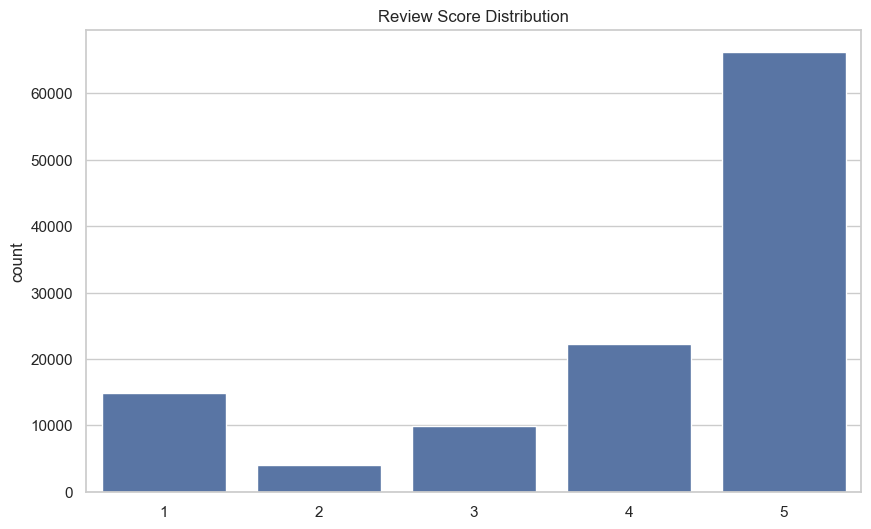

In [18]:
# Visual: Review distribution
if 'review_score' in df.columns:
    plt.figure()
    sns.countplot(x=df[df['review_score'].notna()]['review_score'].astype(int).values)
    plt.title("Review Score Distribution")
    plt.show()

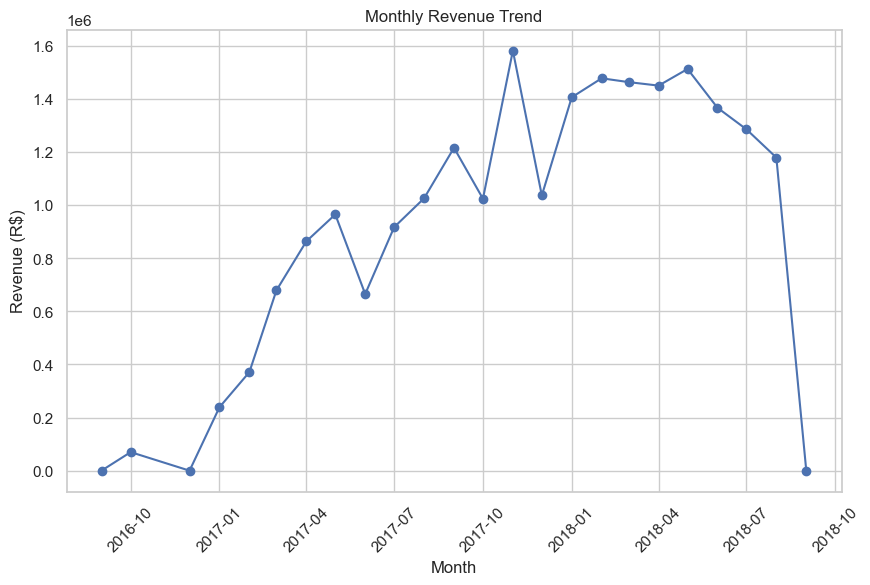

In [19]:
# Visual: Monthly revenue trend
if 'order_month' in df.columns:
    rev_m = df.groupby('order_month', as_index=False)['order_revenue'].sum().sort_values('order_month')
    plt.figure()
    plt.plot(rev_m['order_month'], rev_m['order_revenue'], marker='o')
    plt.title("Monthly Revenue Trend")
    plt.xlabel("Month")
    plt.ylabel("Revenue (R$)")
    plt.xticks(rotation=45)
    plt.show()

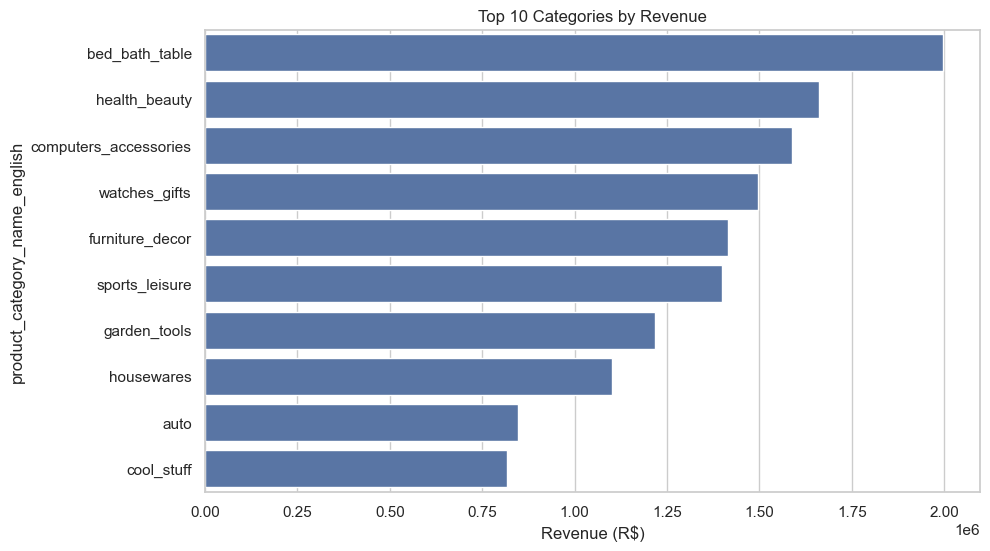

In [20]:
# Visual: Top categories by revenue (English preferred)
cat_col = 'product_category_name_english' if 'product_category_name_english' in df.columns else 'product_category_name'
if cat_col in df.columns:
    cat_rev = df.groupby(cat_col, as_index=False)['order_revenue'].sum().sort_values('order_revenue', ascending=False).head(10)
    plt.figure()
    sns.barplot(y=cat_rev[cat_col], x=cat_rev['order_revenue'])
    plt.title("Top 10 Categories by Revenue")
    plt.xlabel("Revenue (R$)")
    plt.show()

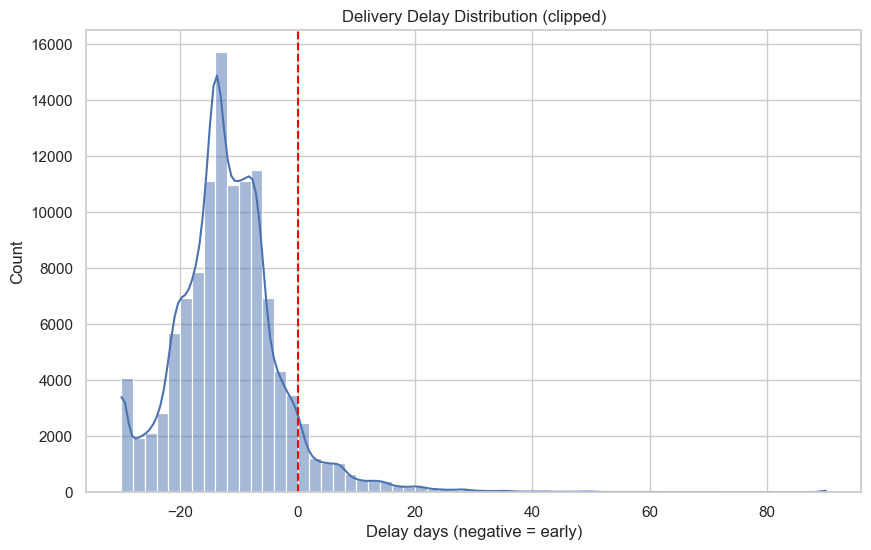

In [21]:
# 4. DIAGNOSTIC: Delay ↔ Satisfaction, Geo & Seller effects
# -----------------------
# 4.1 Delay distribution 
plt.figure()
sns.histplot(df['delay_days'].dropna().clip(-30, 90), bins=60, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Delivery Delay Distribution (clipped)")
plt.xlabel("Delay days (negative = early)")
plt.show()

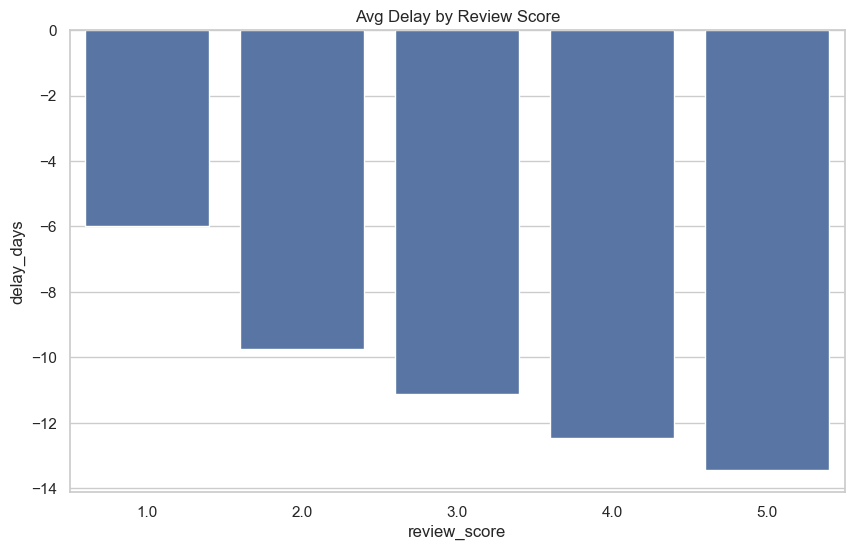

Mann-Whitney p-value (delay higher for low reviews?): 0.0


In [22]:
# 4.2 Avg delay by review score
if 'review_score' in df.columns:
    tmp = df.dropna(subset=['review_score','delay_days']).groupby('review_score', as_index=False)['delay_days'].mean()
    plt.figure()
    sns.barplot(x='review_score', y='delay_days', data=tmp)
    plt.title("Avg Delay by Review Score")
    plt.show()

    # Mann-Whitney test: is delay larger for low-score orders?
    grp = df.dropna(subset=['delay_days','is_low_review'])
    if grp['is_low_review'].nunique()==2:
        u,p = mannwhitneyu(grp.loc[grp.is_low_review==1,'delay_days'], grp.loc[grp.is_low_review==0,'delay_days'], alternative='greater')
        print("Mann-Whitney p-value (delay higher for low reviews?):", p)

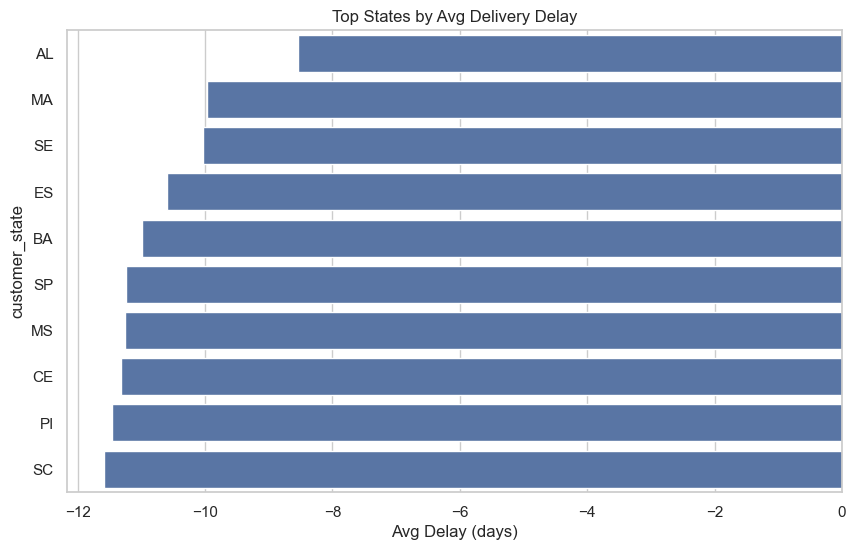

In [23]:
# 4.3 States with highest avg delay
if 'customer_state' in df.columns:
    st_delay = df.groupby('customer_state', as_index=False)['delay_days'].mean().dropna().sort_values('delay_days', ascending=False).head(10)
    plt.figure()
    sns.barplot(x='delay_days', y='customer_state', data=st_delay)
    plt.title("Top States by Avg Delivery Delay")
    plt.xlabel("Avg Delay (days)")
    plt.show()

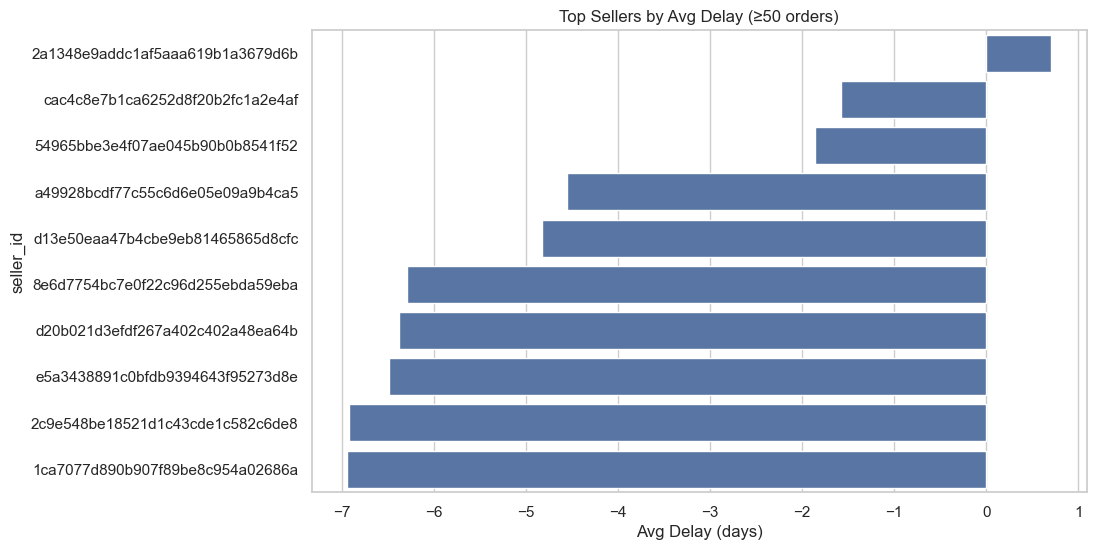

In [24]:
# 4.4 Sellers with worst average delay (>= 50 orders)
if 'seller_id' in df.columns:
    seller_perf = df.groupby('seller_id').agg(n_orders=('order_id','nunique'), avg_delay=('delay_days','mean'), avg_review=('review_score','mean')).reset_index()
    seller_bad = seller_perf[seller_perf['n_orders']>=50].sort_values('avg_delay', ascending=False).head(10)
    plt.figure()
    sns.barplot(x='avg_delay', y='seller_id', data=seller_bad)
    plt.title("Top Sellers by Avg Delay (≥50 orders)")
    plt.xlabel("Avg Delay (days)")
    plt.show()

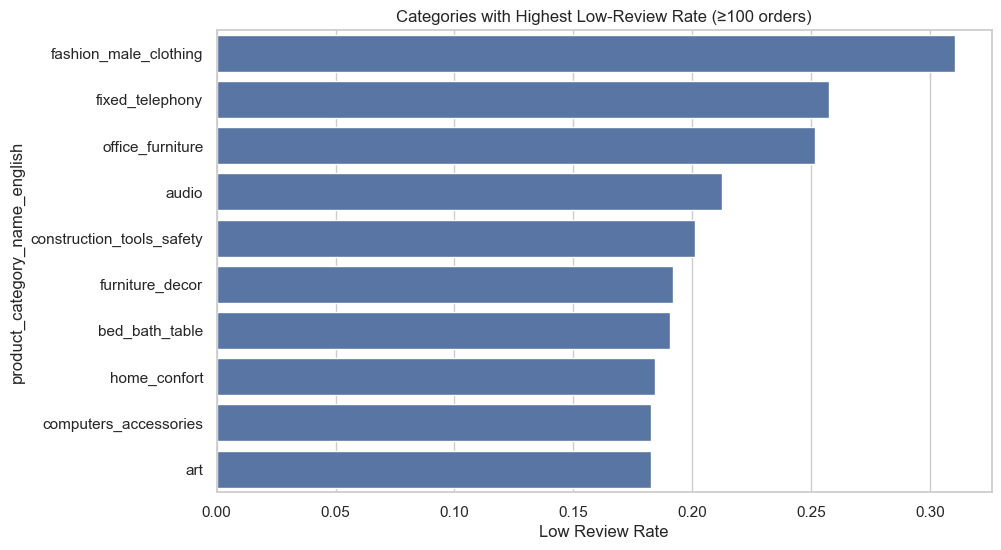

In [25]:
# 4.5 Categories with high low-review rate (>=100 orders)
if cat_col in df.columns:
    cat_stats = df.groupby(cat_col).agg(orders=('order_id','nunique'), low_rate=('is_low_review','mean')).reset_index()
    cat_stats = cat_stats[cat_stats['orders']>=100].sort_values('low_rate', ascending=False).head(10)
    plt.figure()
    sns.barplot(x='low_rate', y=cat_stats[cat_col], data=cat_stats)
    plt.title("Categories with Highest Low-Review Rate (≥100 orders)")
    plt.xlabel("Low Review Rate")
    plt.show()


In [26]:
# --- RFM Feature Engineering ---
import datetime as dt

# Convert order purchase date to datetime if not already
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# Choose a reference date (max date in dataset)
reference_date = df['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

# Calculate RFM metrics
rfm = df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (reference_date - x.max()).days,  # Recency
    'order_id': 'count',  # Frequency
    'payment_value': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['customer_unique_id', 'Recency', 'Frequency', 'Monetary']

# Display summary
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19
2,0000f46a3911fa3c0805444483337064,542,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89


RFM Summary Statistics:
            Recency     Frequency       Monetary
count  95420.000000  95420.000000   95420.000000
mean     243.600377      1.239887     213.968167
std      153.160320      0.852393     645.757464
min        1.000000      1.000000       0.000000
25%      119.000000      1.000000      63.990000
50%      224.000000      1.000000     113.330000
75%      353.000000      1.000000     203.300000
max      729.000000     75.000000  109312.640000


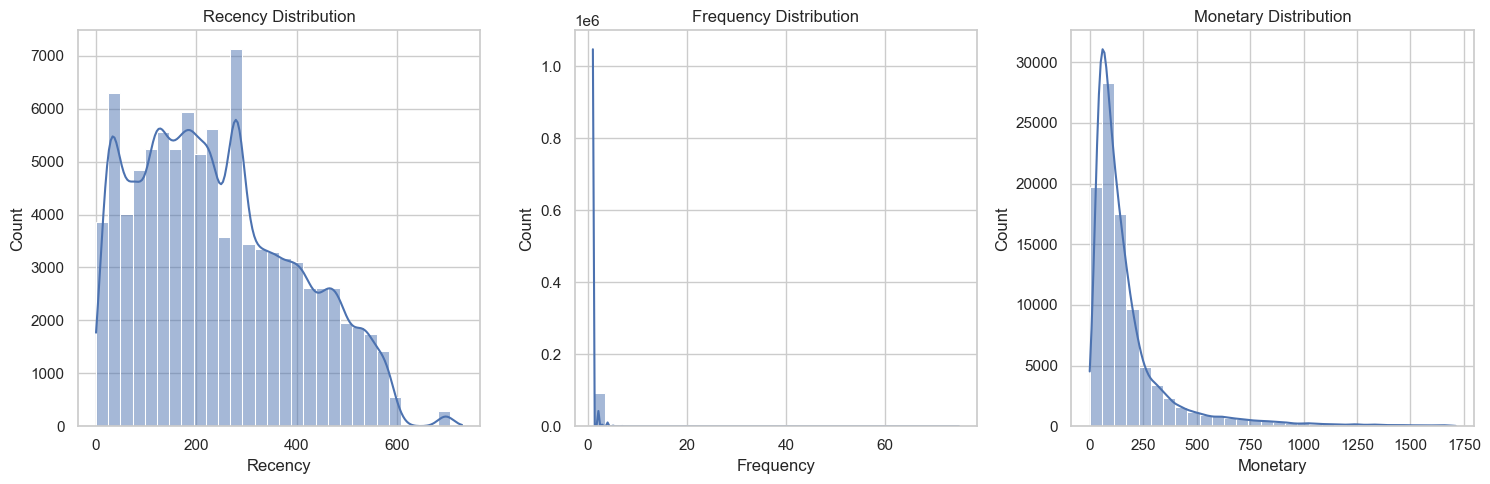

In [27]:
# --- RFM Analysis Summary ---
print("RFM Summary Statistics:")
print(rfm.describe())

# ORemove extreme outliers
rfm = rfm[(rfm['Monetary'] < rfm['Monetary'].quantile(0.99))]

# Visualize RFM Distributions
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
sns.histplot(rfm['Recency'], bins=30, kde=True)
plt.title('Recency Distribution')

plt.subplot(1,3,2)
sns.histplot(rfm['Frequency'], bins=30, kde=True)
plt.title('Frequency Distribution')

plt.subplot(1,3,3)
sns.histplot(rfm['Monetary'], bins=30, kde=True)
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

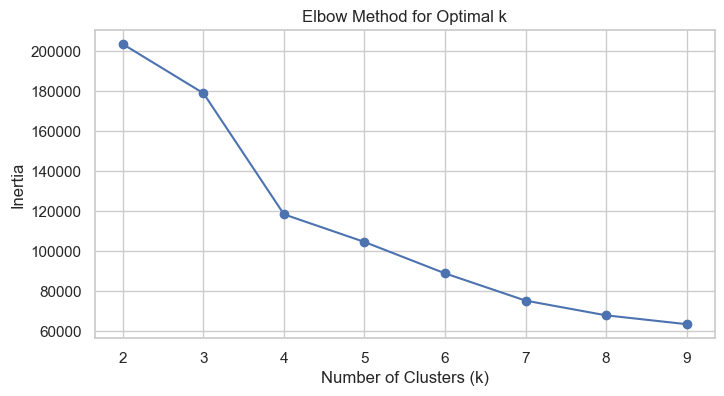

In [28]:
# --- Standardization & K-Means Clustering ---
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import os # Import the os library

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Elbow Method to find optimal k
inertia = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto') # Added n_init='auto' to avoid a future warning
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Fit KMeans with optimal k (you can change if needed)
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto') # Added n_init='auto'
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [29]:
# --- Cluster Profiling ---
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'customer_unique_id': 'count'
}).rename(columns={'customer_unique_id': 'CustomerCount'}).round(2)

cluster_summary = cluster_summary.sort_values('Monetary', ascending=False)
cluster_summary


,Recency,Frequency,Monetary,CustomerCount
Cluster,,,,
2,233.82,1.74,717.25,7085
1,256.22,5.19,646.01,1422
3,396.05,1.11,128.11,36103
0,134.30,1.10,126.23,49855


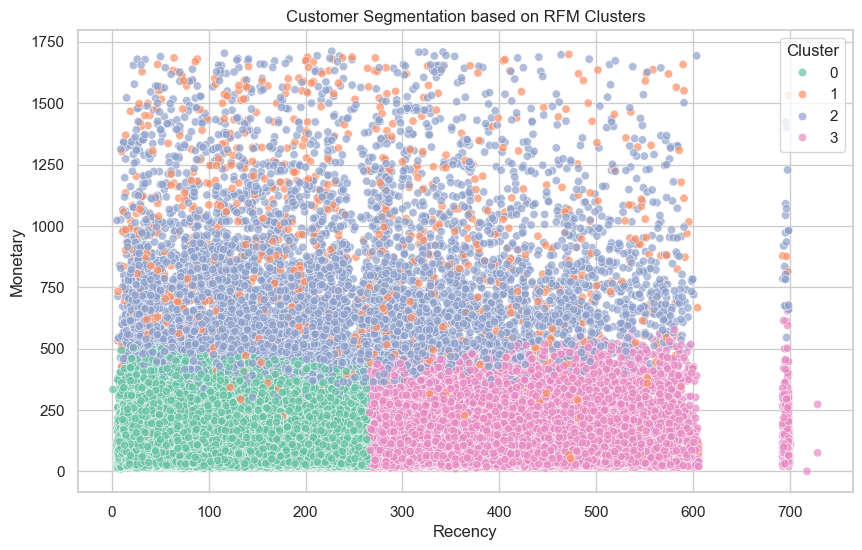

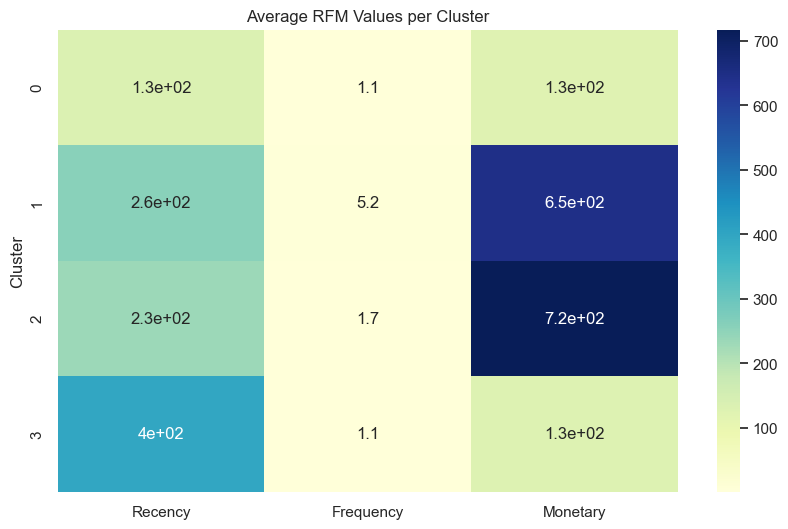

In [30]:
# --- Visualizing Customer Segments ---
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set2', alpha=0.7)
plt.title('Customer Segmentation based on RFM Clusters')
plt.show()

# Heatmap for better comparison
rfm_cluster_avg = rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean()
sns.heatmap(rfm_cluster_avg, annot=True, cmap='YlGnBu')
plt.title('Average RFM Values per Cluster')
plt.show()

In [31]:
# --- Insight Summary ---
print("Cluster Insights:")
for cluster in cluster_summary.index:
    recency = cluster_summary.loc[cluster, 'Recency']
    freq = cluster_summary.loc[cluster, 'Frequency']
    mon = cluster_summary.loc[cluster, 'Monetary']
    print(f"Cluster {cluster}: Avg Recency={recency:.1f}, Frequency={freq:.1f}, Monetary={mon:.1f}")

print("\nBusiness Insights:")
print("• Cluster 0 represents High-Value, Loyal Customers with frequent purchases and high spending.")
print("• Cluster 1 indicates New or Recent Buyers with moderate engagement.")
print("• Cluster 2 shows At-Risk or Dormant customers with low frequency and high recency values.")
print("• Cluster 3 consists of Low-Value customers needing reactivation campaigns.")


Cluster Insights:
Cluster 2: Avg Recency=233.8, Frequency=1.7, Monetary=717.2
Cluster 1: Avg Recency=256.2, Frequency=5.2, Monetary=646.0
Cluster 3: Avg Recency=396.1, Frequency=1.1, Monetary=128.1
Cluster 0: Avg Recency=134.3, Frequency=1.1, Monetary=126.2

Business Insights:
• Cluster 0 represents High-Value, Loyal Customers with frequent purchases and high spending.
• Cluster 1 indicates New or Recent Buyers with moderate engagement.
• Cluster 2 shows At-Risk or Dormant customers with low frequency and high recency values.
• Cluster 3 consists of Low-Value customers needing reactivation campaigns.


In [32]:
# --- Insight Summary ---
print("Cluster Insights Summary:")

print("""
• Cluster 0: High-value, loyal customers — frequent purchases and high monetary value. 
  → Target for loyalty programs and cross-selling.

• Cluster 1: New customers — moderate frequency and spending.
  → Focus on onboarding and engagement campaigns.

• Cluster 2: At-risk customers — low frequency, long recency, declining value.
  → Target with reactivation offers.

• Cluster 3: Low-value customers — infrequent, small orders.
  → Consider budget-friendly promotions or awareness campaigns.
""")

Cluster Insights Summary:

• Cluster 0: High-value, loyal customers — frequent purchases and high monetary value. 
  → Target for loyalty programs and cross-selling.

• Cluster 1: New customers — moderate frequency and spending.
  → Focus on onboarding and engagement campaigns.

• Cluster 2: At-risk customers — low frequency, long recency, declining value.
  → Target with reactivation offers.

• Cluster 3: Low-value customers — infrequent, small orders.
  → Consider budget-friendly promotions or awareness campaigns.

